In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as Fn
from torch.utils.data import TensorDataset,DataLoader
from scipy.io import savemat
from time import time
import os

from PIL import Image
from utils import load_images,iou,iou1,load_PCA,load_1PCA,get_nov_patches,set_nov_patches

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# Define the path to your CSV file
path='./WeizmannHorse/'

# Specify the columns you want to read
with open(path+'train.txt', 'r') as f:
    train = f.read().splitlines()
with open(path+'test.txt', 'r') as f:
    test = f.read().splitlines()

print(len(train),len(test))

159 168


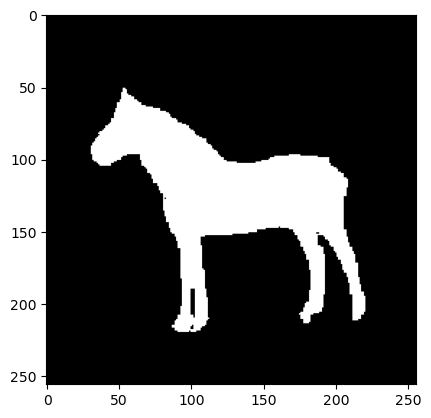

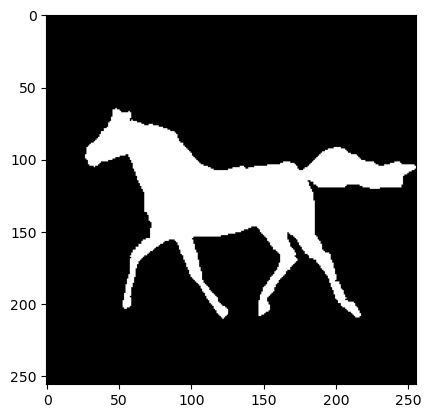

In [3]:
### Build a newdataset with 4 channels, first three for rgb and the last one for the mask:
import os
import torch
from torchvision import transforms
from torchvision.io.image import read_image,write_png

from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop,ToTensor, Normalize, Grayscale, RandomRotation
from torchvision.transforms.v2 import  RandomResize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC # resize the input image using bicubic interpolation, producing a smoother result compared to other interpolation methods like nearest-neighbor or bilinear.

    
    
img=load_images(path+'labels256',train,device,'png').float().to(device)/255
imt=load_images(path+'labels256',test,device,'png').float().to(device)/255

if 0: # Combine Horses with birds
    imgb=load_images(pathb+'labels',trainb,device,'png').float().to(device)/255
    imtb=load_images(pathb+'labels',testb,device,'png').float().to(device)/255

    img=torch.cat((img,imgb),dim=0)
    imt=torch.cat((imt,imtb),dim=0)

plt.imshow(img[0,:,:].cpu(),cmap='gray')
plt.show()
plt.imshow(imt[0,:,:].cpu(),cmap='gray')
plt.show()

In [12]:
# compute 4x4 raves of randomcropresize
# do PCA using raves
from time import time

class RAVEX:
    def __init__(self):
        self.n = 0

    def add(self, X):
        n, p = X.shape
        Sx = torch.sum(X, dim=0)
        Sxx = X.t() @ X
        if self.n == 0:
            self.n = n
            self.mx = Sx / n
            self.mxx = Sxx / n
        else:
            self.mx = self.mx * (self.n / (self.n + n)) + Sx / (self.n + n)
            self.mxx = self.mxx * (self.n / (self.n + n)) + Sxx / (self.n + n)
            self.n = self.n + n

    def add_rave(self, rave):
        n = rave.n
        if self.n == 0:
            self.n = rave.n
            self.mx = rave.mx.clone()
            self.mxx = rave.mxx.clone()
        else:
            n0 = self.n / (self.n + n)
            n1 = n / (self.n + n)
            self.mx = self.mx * n0 + rave.mx * n1
            self.mxx = self.mxx * n0 + rave.mxx * n1
            self.n = self.n + n

    def subtract_mu(self,mu):
        # xx=(x-1*mu)^T(x-1*mu)/n=x^Tx/n-mu^Tmx-mx^Tmu+mu^Tmu
        mpn=mu.view(-1,1)@self.mx.view(1,-1)
        xx=self.mxx-mpn-mpn.t()+mu.view(-1,1)@mu.view(1,-1)
        return xx,self.mx-mu
    
    def multiply(self,xx,mx,si):
        xx=xx*si.view(-1,1)
        xx=xx*si.view(1,-1)
        return xx,mx*si

    def standardize_x(self):
        # standardize the raves for x
        var_x = torch.diag(self.mxx) - self.mx ** 2
        std_x = torch.sqrt(var_x)
        Pi = 1 / std_x

        XXn = self.mxx - self.mx.view(-1, 1) @ self.mx.view(1, -1)
        XXn *= Pi.view(1, -1)
        XXn *= Pi.view(-1, 1)
        self.sxi = Pi.clone()
        return (XXn, Pi)
   
    def add_onlyX(self, X, mxx_cpu=False):
        n, p = X.shape
        Sx = torch.sum(X, dim=0)  # p x 1
        Sxx = (X.t() @ X)  # p x p
        if self.n == 0:
            self.n = n
            self.mx = Sx / n
            self.mxx = Sxx / n
        else:
            self.mx = (self.mx * (self.n / (self.n + n)) + Sx / (self.n + n))
            self.mxx = (self.mxx * (self.n / (self.n + n)) + Sxx / (self.n + n))
            self.n = (self.n + n)
   
    def cov_matrix(self):
        XXn = self.mxx - self.mx.unsqueeze(0).T@self.mx.unsqueeze(0)
        return XXn,self.mx#,self.mxx,self.n

def _transfRC1(pad,nx2): # applied to a PIL image
    return Compose([
        RandomResize(256-pad,256+pad,interpolation=InterpolationMode.BILINEAR),
        RandomRotation(pad),
        RandomCrop(256,pad,padding_mode='edge'),
        Resize([nx2,nx2], interpolation=InterpolationMode.BILINEAR)
     ])

def train_1rave(rave,xo,nx,ngrid,niter):
    # train one rave from a grid of ngrid x ngrid patches with niter perturbations
    # image size nx
    n=xo.shape[0]
    nxpatch=nx//ngrid
    for e in range(niter):
#        print(xo.shape)
        im=_transfRC1(15,nx)(xo).to(device)
        im=(im>0.5).float()
        pa=get_nov_patches(im,nxpatch)
        #print(pa.shape)
        nr=pa.shape[1]
        nc=pa.shape[2]
        for i in range(nr):     
            for j in range(nc):
            #xi=im.reshape(-1,nx**2)
                rave.add(pa[:,i,j,:])

def train_raves(rave,xo,nx,ngrid,niter):
    # train grid of ngrid x ngrid raves with niter perturbations
    # image size nx
    n=xo.shape[0]
    nxpatch=nx//ngrid
    #print(nxpatch)
    for e in range(niter):
#        print(xo.shape)
        im=_transfRC1(15,nx)(xo).to(device)
        im=(im>0.5).float()
        pa=get_nov_patches(im,nxpatch).squeeze()
        npa=len(pa)
        for i in range(npa):     
            #xi=im.reshape(-1,nx**2)
            rave[i].add(pa[i])
    
def train_1PCA(rave):
    xx,mx=rave.cov_matrix()
    u,d,v=torch.linalg.svd(xx)
    P=v[0:1024,:].cpu()
    #print(xx.shape)
    #plt.plot(d.cpu()**0.5)
    return mx,P

def train_PCAs(rave):
    mx=[]
    P=[]
    for i in range(len(rave)):
        xx,mxi=rave[i].cov_matrix()
        u,d,v=torch.linalg.svd(xx)
        mx.append(mxi)
        P.append(v[0:128,:].cpu())
    #print(xx.shape)
    #plt.plot(d.cpu()**0.5)
    return mx,P

def train_PCAs_grid(img,nx,ngrid,niter):
    t0=time()
    rave=[]
    for i in range(ngrid**2):
        rave.append(RAVEX())
    train_raves(rave,img,nx,ngrid,niter)
    t1=time()
    print('%d, %d, time=%.1f'%(rave[0].n,rave[0].mx.shape[0],t1-t0))
    mx,P=train_PCAs(rave)
    return mx,P

def train_1PCA_grid(img,nx,ngrid,niter):
    t0=time()
    rave=RAVEX()
    train_1rave(rave,img,nx,ngrid,niter)
    t1=time()
    print('%d, %d, time=%.1f'%(rave.n,rave.mx.shape[0],t1-t0))
    mx,P=train_1PCA(rave)
    return mx,P

ngrid=8
nx=256
#x=resize(nx)(img).to(device)
torch.cuda.empty_cache()
for nit in [1,10]:
    for r in range(5):
        t0=time()
#        if nx==256:
        mx,P=train_1PCA_grid(img,nx,ngrid,nit)
#        else:
#            mx,P=train_1PCA_grid(x,nx,ngrid,nit)
        #mx,P=train_PCAs_grid(img,nx,ngrid,nit)
        #plt.imshow(im[0].squeeze(),cmap='gray')
        print('%d iter, run %d, time=%.0f'%(nit,r,time()-t0))
        name='pca_horse_%d_%dx%d_%dit_%d.pth'%(nx,ngrid,ngrid,nit,r)
        torch.save({'P':P,'mx':mx},name)
print('done.')

10176, 1024, time=0.1
1 iter, run 0, time=1
10176, 1024, time=0.0
1 iter, run 1, time=0
10176, 1024, time=0.0
1 iter, run 2, time=0
10176, 1024, time=0.0
1 iter, run 3, time=0
10176, 1024, time=0.0
1 iter, run 4, time=0
101760, 1024, time=0.2
10 iter, run 0, time=0
101760, 1024, time=0.2
10 iter, run 1, time=0
101760, 1024, time=0.2
10 iter, run 2, time=0
101760, 1024, time=0.2
10 iter, run 3, time=0
101760, 1024, time=0.2
10 iter, run 4, time=0
done.


pca_horse_256_8x8_1it_0.pth
torch.Size([256, 1024])
1 0 0.998 0.998
pca_horse_256_8x8_1it_1.pth
torch.Size([256, 1024])
1 1 0.998 0.998
pca_horse_256_8x8_1it_2.pth
torch.Size([256, 1024])
1 2 0.998 0.998
pca_horse_256_8x8_1it_3.pth
torch.Size([256, 1024])
1 3 0.998 0.998
pca_horse_256_8x8_1it_4.pth
torch.Size([256, 1024])
1 4 0.997 0.997
pca_horse_256_8x8_10it_0.pth
torch.Size([256, 1024])
10 0 0.999 0.999
pca_horse_256_8x8_10it_1.pth
torch.Size([256, 1024])
10 1 0.999 0.999
pca_horse_256_8x8_10it_2.pth
torch.Size([256, 1024])
10 2 0.999 0.999
pca_horse_256_8x8_10it_3.pth
torch.Size([256, 1024])
10 3 0.999 0.999
pca_horse_256_8x8_10it_4.pth
torch.Size([256, 1024])
10 4 0.999 0.999
   niter  r       iou      iout
0      1  0  0.997525  0.997630
1      1  1  0.997873  0.997946
2      1  2  0.997837  0.997846
3      1  3  0.997586  0.997639
4      1  4  0.997244  0.997231
5     10  0  0.998674  0.998761
6     10  1  0.998644  0.998762
7     10  2  0.998680  0.998747
8     10  3  0.998653 

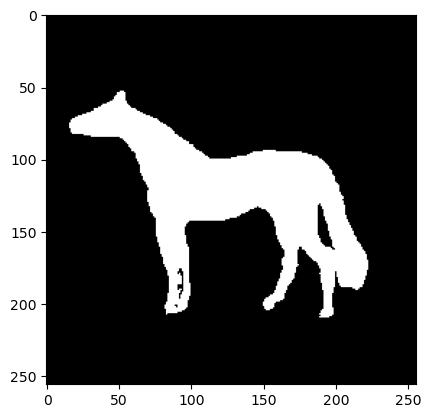

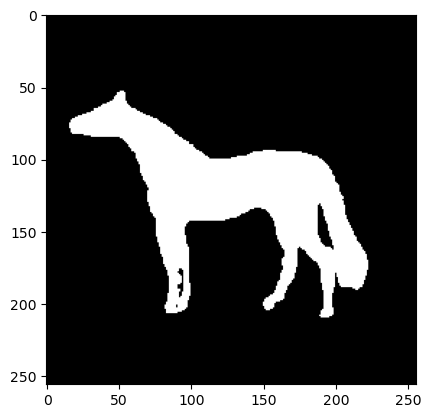

In [19]:
import pandas as pd
from utils import resize

def get_coeffs1(im,mx,P):
    sz=int(mx.shape[0]**0.5)
    pa=get_nov_patches(im.to(device),sz) #gives 8x8 patches for image size(256,256)
    c=(pa-mx.unsqueeze(0).unsqueeze(1).unsqueeze(2))@P.t()
    return c

def get_coeffs(im,mx,P):
    """
    Function to calculate PCA-coefficients or PCA-loadings for an image

    Args:
        im= image_array: Tensor.
        mx= list of running averages
        P= list of PC-vectors: list of npa elements, each element of size (256,128*128)

    Returns:
        c= PCA-coefficients , shape= (number of images,number of patches,256)
    """
    sz=int(im.shape[1]/len(mx)**0.5)
    pa=get_nov_patches(im.to(device),sz) #gives 16 patches for image size(128,128)
    nim,nr,nc,_=pa.shape # 16 = number of elements in P = number of patches
    c=torch.zeros(nim,nr,nc,P[0].shape[0]).to(device) # shape=(159,8,8,64)
    i=0
    for ir in range(nr):
        for ic in range(nc):
            ci=(pa[:,ir,ic,:]-mx[i])@P[i].t() #centering the patches by subtracting the mean
                                      # find loadings by multiplying the centered pixels and PCs
            #print(ci.shape)
            c[:,ir,ic,:]=ci #loading or PC coeff for patch i
            i+=1
    return c

## Function to recreate the image tensor from the PCA coefficients:

def get_rec_pca(c,mx,P):
    n,nr,nc,_=c.shape
    d=mx[0].shape[0]
    xr=torch.zeros(n,nr,nc,d,device=c.device)
    i=0
    for ir in range(nr):
        for ic in range(nc): # controls the patch
            ci=c[:,ir,ic,:]
            xr[:,ir,ic,:]=ci@P[i]+mx[i] #reconstructed image array = dot(coeff,PC)+mean
            i+=1
    return xr


nx=256
ngrid=8
res={'niter':[],'r':[],'iou':[],'iout':[]}
miou=[]
if nx==256:
    x=img.to(device)
    xt=imt.to(device)
else:
    x=resize(nx)(img).to(device)
    xt=resize(nx)(imt).to(device)

nc=256
for nit in [1,10]:
    ious=[]
    iouts=[]
    for r in range(5):
        #name='c:/training/pca-unet/pca1_%d_%dx%d_%dit_%d.pth'%(nx,ngrid,ngrid,nit,r)
        name='pca_horse_%d_%dx%d_%dit_%d.pth'%(nx,ngrid,ngrid,nit,r)
        print(name)
        if 0: # grid of PCAs
            mx,P=load_PCA(name,device,nc)
            c=get_coeffs(x,mx,P)
            xr=get_rec_pca(c,mx,P)
            xt=imt.to(device)
            c=get_coeffs(xt,mx,P)
            xrt=get_rec_pca(c,mx,P)
        else: # one PCA
            mx,P=load_1PCA(name,device,nc)
            print(P.shape)
            c=get_coeffs1(x,mx,P)
            xr=c@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)    
            c=get_coeffs1(xt,mx,P)
            xrt=c@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)
        xr=set_nov_patches(xr,nx//ngrid)
        xrt=set_nov_patches(xrt,nx//ngrid)
        ioui=torch.mean(iou(x.reshape(-1,nx**2)>0.5,xr.reshape(-1,nx**2)>0.5)).item()
        iout=torch.mean(iou(xt.reshape(-1,nx**2)>0.5,xrt.reshape(-1,nx**2)>0.5)).item()
        res['r'].append(r)
        res['niter'].append(nit)
        res['iou'].append(ioui)
        res['iout'].append(iout)
        ious.append(ioui)
        iouts.append(iout)
        print('%d %d %1.3f %1.3f'%(nit,r,ioui,iout))
df=pd.DataFrame(res)
print(df)
name='res_PCA_.csv'
df.to_csv(name)
it=df['niter']
st=''
stt=''
for nit in np.unique(it):
    ious=df['iou'][it==nit]
    iouts=df['iout'][it==nit]
    r=(np.mean(ious),np.std(ious))
    rt=(np.mean(iouts),np.std(iouts))
    sti='&%1.3f(%1.3f) '%r
    stti='&%1.3f(%1.3f) '%rt
    st=st+sti
    stt=stt+stti
print(st)
print(stt)
#print(torch.mean(iou(xt.reshape(-1,128**2)>0.5,xtr.reshape(-1,128**2).cpu()>0.5)))
i=11
plt.imshow(xt[i,:,:].cpu().reshape(nx,nx)>0.5,cmap='gray')
plt.show()
plt.imshow(xrt[i,:].cpu().reshape(nx,nx)>0.5,cmap='gray')

In [20]:
from torchvision.datasets import VOCSegmentation
data=VOCSegmentation('d:/datasets/PascalVOC2012','2012','train',download=True)
datat=VOCSegmentation('d:/datasets/PascalVOC2012','2012','val',download=True)

Using downloaded and verified file: d:/datasets/PascalVOC2012\VOCtrainval_11-May-2012.tar
Extracting d:/datasets/PascalVOC2012\VOCtrainval_11-May-2012.tar to d:/datasets/PascalVOC2012
Using downloaded and verified file: d:/datasets/PascalVOC2012\VOCtrainval_11-May-2012.tar
Extracting d:/datasets/PascalVOC2012\VOCtrainval_11-May-2012.tar to d:/datasets/PascalVOC2012


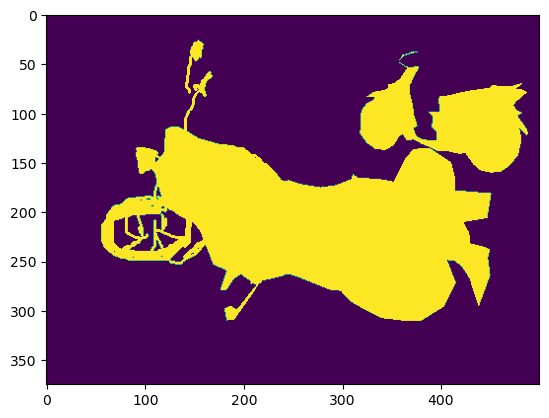

In [18]:
from torchvision import transforms
t=transforms.ToTensor()
i=12
x,y=data.__getitem__ (i)
y1=(t(y)*255).long()
plt.imshow((y1==14).squeeze())

In [14]:
y1[(y1>0)&(y1<255)]

tensor([15, 15, 15,  ..., 14, 14, 14])

In [110]:
# Train Pascal VOC
def _transfRC1(pad,h,w): 
    return Compose([
        #RandomResize(256-pad,256+pad,interpolation=InterpolationMode.BILINEAR),
        RandomRotation(pad),
        RandomCrop([h,w],pad,padding_mode='edge')
     ])

def add_to_rave(rave,img,nxpatch,niter):
    # train one rave from a grid of patches with niter perturbations
    _,h,w=img.shape
    for e in range(niter):
#        print(xo.shape)
        im=_transfRC1(15,h,w)(img).to(device)
        im=(im>0.5).float()
        pa=get_nov_patches(im,nxpatch).squeeze()
        pa=pa.view(-1,pa.shape[2])
        rave.add(pa)

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog',
         'horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
ngrid=8
nx=256
nit=10
t=transforms.ToTensor()
nimg=data.__len__ ()
for r in range(1,5):
    rave=RAVEX()
    for i in range(nimg):
        x,y=data.__getitem__ (i)
        #plt.imshow(y)
        y=(t(y)*255).long().to(device)
        _,h,w=y.shape
        u=torch.unique(y.view(-1))
        u=list(u.cpu().numpy())
        if min(h,w)<256:
            print(i,h,w)
            y=Resize(256, interpolation=InterpolationMode.BILINEAR)(y.float()).long()
        for l in u:
            if l in [0,255]:
                continue
            yl=(y==l).float().to(device)
            add_to_rave(rave,yl,32,nit)
    mx,P=train_1PCA(rave)
    name='c:/training/PCA-Unet/pca_voc_32_%dit_%d.pth'%(nit,r)
    torch.save({'P':P,'mx':mx},name)

71 212 320
72 238 500
150 254 500
258 240 320
260 240 320
341 225 300
360 240 320
373 237 500
414 241 500
497 230 500
509 218 500
543 208 360
670 240 360
674 202 500
750 112 500
897 239 500
910 175 500
932 198 257
1097 213 500
1388 326 246
71 212 320
72 238 500
150 254 500
258 240 320
260 240 320
341 225 300
360 240 320
373 237 500
414 241 500
497 230 500
509 218 500
543 208 360
670 240 360
674 202 500
750 112 500
897 239 500
910 175 500
932 198 257
1097 213 500
1388 326 246
71 212 320
72 238 500
150 254 500
258 240 320
260 240 320
341 225 300
360 240 320
373 237 500
414 241 500
497 230 500
509 218 500
543 208 360
670 240 360
674 202 500
750 112 500
897 239 500
910 175 500
932 198 257
1097 213 500
1388 326 246
71 212 320
72 238 500
150 254 500
258 240 320
260 240 320
341 225 300
360 240 320
373 237 500
414 241 500
497 230 500
509 218 500
543 208 360
670 240 360
674 202 500
750 112 500
897 239 500
910 175 500
932 198 257
1097 213 500
1388 326 246


In [116]:
miou=np.zeros((5,20))
miou.shape

(5, 20)

In [26]:
from utils import make_divisible

def reconstructPCA(img,mx,P):
    _,h,w=img.shape
    im,_=make_divisible(img,32)
    im=im.to(device)
    #print(img.shape,im.shape)
    c=get_coeffs1(im,mx,P)
    xr=c@P+mx.unsqueeze(0).unsqueeze(1).unsqueeze(2)    
    xr=set_nov_patches(xr,32)
    #print(xr.shape)
    seg=(xr>0.5).float().squeeze()
    seg=seg[:h,:w]
    return seg

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog',
         'horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
ngrid=8
nx=256
nit=10
t=transforms.ToTensor()
nimg=datat.__len__ ()
miou=np.zeros((5,20))
for r in range(5):
    #name='c:/training/PCA-Unet/pca_voc_32_%dit_%d.pth'%(nit,r)
    name='pca_horse_%d_%dx%d_%dit_%d.pth'%(nx,ngrid,ngrid,nit,r)
    mx,P=load_1PCA(name,device,64)
    ious={}
    for i in range(nimg):
        x,y=datat.__getitem__ (i)
        #plt.imshow(y)
        y=(t(y)*255).long().to(device)
        _,h,w=y.shape
        u=torch.unique(y.view(-1))
        u=list(u.cpu().numpy())
        if min(h,w)<256:
            print(r,i,h,w)
            y=Resize(256, interpolation=InterpolationMode.BILINEAR)(y.float()).long()
        for l in u:
            if l in [0,255]:
                continue
            yl=(y==l).float()
            xr=reconstructPCA(yl,mx,P)
            ioul=iou1(yl.reshape(-1)>0.5,xr.reshape(-1)>0.5)
            if l in ious.keys():
                ious[l].append([i,ioul])
            else:
                ious[l]=[[i,ioul]]
            #print(i,l,ioul)
    for l in range(1,21):
        if l not in ious.keys():
            continue
        ioul=np.array(ious[l])
        #print(ioul.shape)
        ioul=ioul[:,1]
        miou[r,l-1]=np.mean(ioul)

print(miou)
name='res_PascalVOC_.csv'
np.savetxt(name,miou,'%.6f')

for l in range(20):
    mi=np.mean(miou[:,l])
    si=np.std(miou[:,l])
    print('%s &%.3f(%.3f)\\\\'%(classes[l],mi,si))
    print('\hline')

0 16 230 500
0 77 240 320
0 125 320 240
0 128 176 500
0 148 500 174
0 276 212 320
0 287 208 344
0 357 213 320
0 358 213 320
0 454 500 191
0 494 151 500
0 530 500 255
0 668 215 288
0 793 500 224
0 798 243 500
0 925 240 320
0 948 200 300
0 974 252 500
0 1018 245 300
0 1090 196 500
0 1207 216 500
0 1361 219 300
0 1424 225 400
1 16 230 500
1 77 240 320
1 125 320 240
1 128 176 500
1 148 500 174
1 276 212 320
1 287 208 344
1 357 213 320
1 358 213 320
1 454 500 191
1 494 151 500
1 530 500 255
1 668 215 288
1 793 500 224
1 798 243 500
1 925 240 320
1 948 200 300
1 974 252 500
1 1018 245 300
1 1090 196 500
1 1207 216 500
1 1361 219 300
1 1424 225 400
2 16 230 500
2 77 240 320
2 125 320 240
2 128 176 500
2 148 500 174
2 276 212 320
2 287 208 344
2 357 213 320
2 358 213 320
2 454 500 191
2 494 151 500
2 530 500 255
2 668 215 288
2 793 500 224
2 798 243 500
2 925 240 320
2 948 200 300
2 974 252 500
2 1018 245 300
2 1090 196 500
2 1207 216 500
2 1361 219 300
2 1424 225 400
3 16 230 500
3 77 240 320

In [27]:
print(miou)
name='res_PascalVOC_.csv'
np.savetxt(name,miou,'%.6f')

[[0.95339674 0.81155379 0.96739585 0.96027246 0.98122764 0.99507443
  0.97623169 0.99401545 0.93835772 0.98540124 0.99306217 0.98975887
  0.9797492  0.9768563  0.97408683 0.87613501 0.97849039 0.99552103
  0.99321704 0.99451775]
 [0.95356679 0.81183014 0.96765952 0.95966762 0.9811165  0.99503664
  0.97554158 0.99393785 0.93844244 0.9853815  0.99288078 0.98969539
  0.97970098 0.97657821 0.97397297 0.87601514 0.97826423 0.995429
  0.99308251 0.99436776]
 [0.95261687 0.8102591  0.96789879 0.96003391 0.98062396 0.99490735
  0.9756122  0.99394668 0.93831994 0.98541638 0.99292899 0.989746
  0.97959723 0.97663182 0.97395617 0.87564493 0.97841181 0.99536959
  0.99316219 0.99453568]
 [0.95341471 0.81120358 0.96802339 0.9597579  0.98101571 0.99501277
  0.97545677 0.99389068 0.93812645 0.98539718 0.99284131 0.98965711
  0.97973993 0.97670672 0.97398683 0.87532874 0.97834156 0.99537591
  0.99313981 0.99451887]
 [0.95303989 0.81166642 0.96815363 0.96037329 0.98125618 0.99504401
  0.97533863 0.99388

In [130]:
miou=np.loadtxt('res_PascalVOC_HB.csv')
print(miou.shape)
miou1=np.loadtxt('res_PascalVOC.csv',delimiter=',')
print(miou1.shape)
for l in range(20):
    mi=np.mean(miou[:,l])
    si=np.std(miou[:,l])
    mi1=np.mean(miou1[:,l])
    si1=np.std(miou1[:,l])
    print('%s &%.3f(%.3f) &%.3f(%.3f)\\\\'%(classes[l],mi,si,mi1,si1))
    print('\hline')

(5, 20)
(5, 20)
aeroplane &0.954(0.000) &0.955(0.000)\\
\hline
bicycle &0.813(0.000) &0.811(0.000)\\
\hline
bird &0.968(0.000) &0.968(0.000)\\
\hline
boat &0.959(0.000) &0.961(0.000)\\
\hline
bottle &0.982(0.000) &0.981(0.000)\\
\hline
bus &0.995(0.000) &0.995(0.000)\\
\hline
car &0.977(0.000) &0.976(0.000)\\
\hline
cat &0.994(0.000) &0.994(0.000)\\
\hline
chair &0.938(0.000) &0.939(0.000)\\
\hline
cow &0.986(0.000) &0.985(0.000)\\
\hline
diningtable &0.993(0.000) &0.993(0.000)\\
\hline
dog &0.990(0.000) &0.990(0.000)\\
\hline
horse &0.980(0.000) &0.980(0.000)\\
\hline
motorbike &0.977(0.000) &0.977(0.000)\\
\hline
person &0.974(0.000) &0.974(0.000)\\
\hline
pottedplant &0.876(0.000) &0.875(0.000)\\
\hline
sheep &0.978(0.000) &0.978(0.000)\\
\hline
sofa &0.996(0.000) &0.995(0.000)\\
\hline
train &0.993(0.000) &0.993(0.000)\\
\hline
tvmonitor &0.994(0.000) &0.995(0.000)\\
\hline


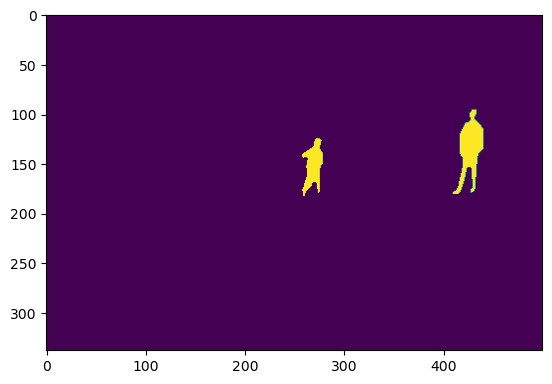

In [108]:
l=15
yl=(y==l).float()
xr=reconstructPCA(yl,mx,P)
iou1(yl.reshape(-1)>0.5,xr.reshape(-1)>0.5)
plt.imshow(xr.squeeze().cpu(),cmap='gray')

In [31]:
classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog',
         'horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']
for l in range(1,21):
    if l not in ious.keys():
        continue
    ioul=np.array(ious[l])[:,1]
    mioui=np.mean(ioul)
    siou=np.std(ioul)
    print('%s &%.3f(%.3f)'%(classes[l-1],mioui,siou))

aeroplane &0.953(0.129)
bicycle &0.812(0.186)
bird &0.968(0.064)
boat &0.960(0.080)
bottle &0.981(0.028)
bus &0.995(0.007)
car &0.975(0.061)
cat &0.994(0.005)
chair &0.939(0.144)
cow &0.985(0.018)
diningtable &0.993(0.011)
dog &0.990(0.014)
horse &0.980(0.035)
motorbike &0.977(0.050)
person &0.974(0.049)
pottedplant &0.875(0.201)
sheep &0.978(0.029)
sofa &0.995(0.004)
train &0.993(0.008)
tvmonitor &0.994(0.008)
